## Bidirectional RNN + LSTM Model

In [104]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Loading and Preprocessing Data

In [158]:
# Function to calculate RSI
def calculate_rsi(close_prices, period=14):
    delta = close_prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(close_prices, short_period=12, long_period=26, signal_period=9):
    short_ema = close_prices.ewm(span=short_period, adjust=False).mean()
    long_ema = close_prices.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd - signal  # MACD Histogram

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20):
    sma = close_prices.rolling(window=window).mean()
    std = close_prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

# Function to calculate ATR (Average True Range)
def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = high_low.to_frame(name='HL').join(high_close.to_frame(name='HC')).join(low_close.to_frame(name='LC')).max(axis=1)
    return tr.rolling(period).mean()

# Fetch and preprocess stock data
def fetch_stock_data(ticker, start='2020-01-01', end='2025-01-01'):
    data = yf.download(ticker, start=start, end=end)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[0] for col in data.columns]

    # Calculate returns and technical indicators
    data['Return'] = data['Close'].pct_change()
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(data['Close'], 14)
    data['MACD'] = calculate_macd(data['Close'])
    data['Bollinger_Upper'], data['Bollinger_Lower'] = calculate_bollinger_bands(data['Close'])
    data['ATR'] = calculate_atr(data)

    # Forward return for labeling
    data['Forward_Return'] = data['Return'].shift(-1)

    # New multi-class labeling strategy
    data['Target'] = np.where(data['Forward_Return'] > 0.01, 2, # Buy
                              np.where(data['Forward_Return'] < -0.01, 0,  # Sell
                                 1))  # Hold

    data.dropna(inplace=True)

    #print(f"Class distribution: {data['Target'].value_counts()}")

    return data[['Close', 'Volume', 'Return', 'MA5', 'MA20', 'MA50', 'MA200', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'ATR', 'Target']]

# Convert dataset into sequences for LSTM
def create_sequences(data, sequence_length=30):
    features = data.drop(columns=['Target'])
    labels = data['Target']

    # Normalize features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features_scaled[i:i+sequence_length])
        y.append(labels.iloc[i+sequence_length])

    X, y = np.array(X), np.array(y)
    
    # One-hot encode labels for categorical classification
    y = to_categorical(y, num_classes=3)

    return X, y, scaler

In [169]:
# Load data
ticker = 'GOOG'
data = fetch_stock_data(ticker)

# Preprocess data
X, y, scaler = create_sequences(data, sequence_length=30)

# Train-test split (time-based)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

[*********************100%***********************]  1 of 1 completed


In [170]:
data['Target'].value_counts()

Target
1    526
2    281
0    251
Name: count, dtype: int64

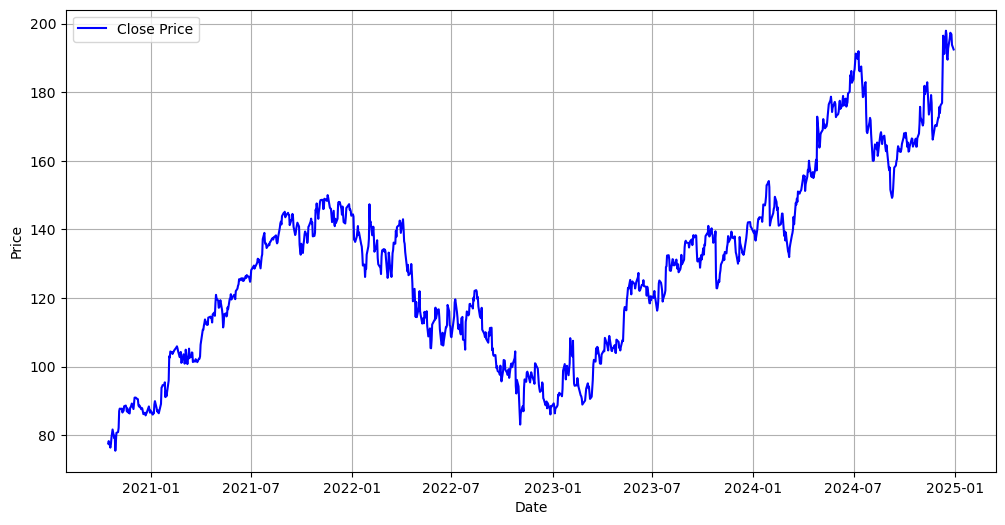

In [171]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
#plt.plot(data.index, data['MA5'], label='5-day MA', color='orange')
#plt.plot(data.index, data['MA20'], label='20-day MA', color='green')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Create Bidirectional RNN + LSTM Architecture

In [172]:
# input shape (time steps, features)
input_shape = (30, 12)

# build model
model = Sequential([
    # Input layer
    Input(shape=input_shape),
    
    # Bidirectional SimpleRNN for better feature learning from both directions
    Bidirectional(SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.3),  # Increased dropout for better regularization
    
    # Add more LSTM layers to capture longer sequences and complex dependencies
    LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),  # Increased units
    Dropout(0.3),
    
    LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),  # Deeper LSTM layer
    Dropout(0.3),
    
    # Additional LSTM layer with reduced return_sequences
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    
    # Add more Dense layers to further process the features
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Larger Dense layer
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Another Dense layer for complexity
    
    # Output layer with softmax for classification (3 classes)
    Dense(3, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 30, 256)        │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 30, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,963 (3.15 MB)

 Trainable params: 824,835 (3.15 MB)

 Non-trainable params: 128 (512.00 B)

### Model Training

In [173]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.3724 - loss: 11.3344 - val_accuracy: 0.5146 - val_loss: 8.1164 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4466 - loss: 7.4084 - val_accuracy: 0.5146 - val_loss: 5.5623 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4919 - loss: 5.1761 - val_accuracy: 0.5146 - val_loss: 4.2073 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4565 - loss: 4.0090 - val_accuracy: 0.5146 - val_loss: 3.4313 - learning_rate: 0.0010
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.4758 - loss: 3.2715 - val_accuracy: 0.5146 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5077 - loss: 2.7542 - val_accuracy: 0.5146 - val_loss: 2.5377 - learning_rate: 0.0010
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5207 - loss: 2.4044 - val_a

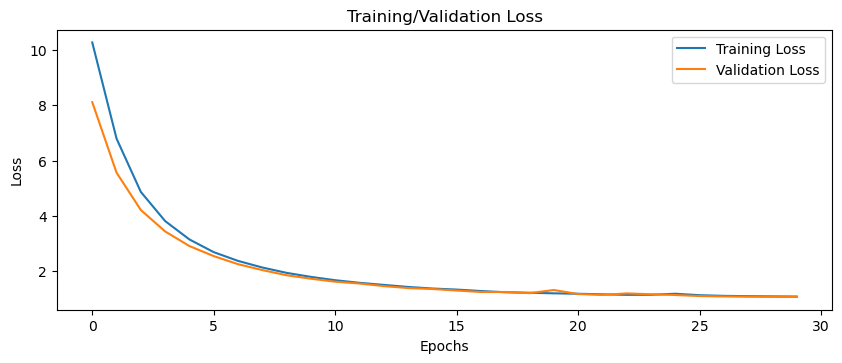

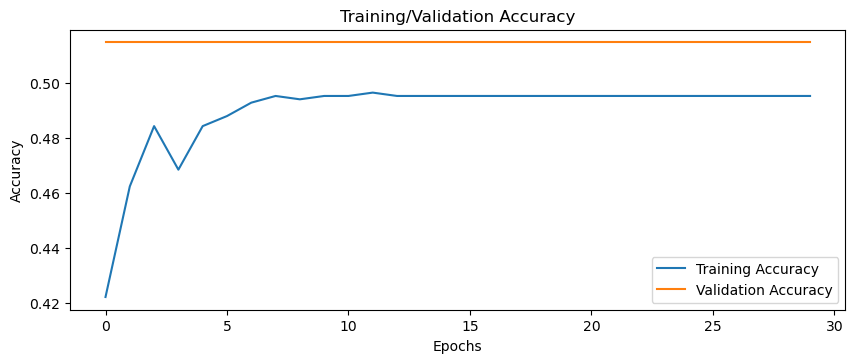

In [174]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], linestyle='-', label='Training Loss')
plt.plot(history.history['val_loss'], linestyle='-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], linestyle='-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training/Validation Accuracy')
plt.legend()

plt.show()

### Bidirectional RNN + LSTM Model Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


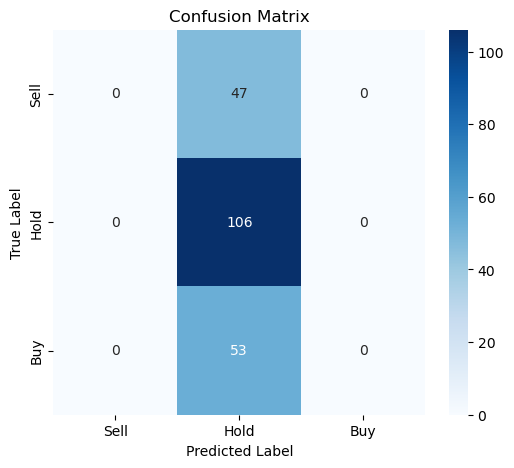

Classification Report:
               precision    recall  f1-score   support

        Sell       0.00      0.00      0.00        47
        Hold       0.51      1.00      0.68       106
         Buy       0.00      0.00      0.00        53

    accuracy                           0.51       206
   macro avg       0.17      0.33      0.23       206
weighted avg       0.26      0.51      0.35       206



/Users/andy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [175]:
# Convert one-hot encoded labels to class labels if necessary
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Get classification predictions (logits outputs)
test_preds = model.predict(X_test)

# Convert logits to predicted labels
pred_labels = np.argmax(test_preds, axis=1)  # Use the correct variable 'test_preds'

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, pred_labels)

# Display confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Sell', 'Hold', 'Buy'], yticklabels=['Sell', 'Hold', 'Buy'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report (Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(y_test, pred_labels, target_names=['Sell', 'Hold', 'Buy']))